<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/dqn_training_multi_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#Protocol Buffer Fix (for TensorFlow)
!pip install --upgrade protobuf
!pip install protobuf==3.20.3


  Using cached protobuf-6.30.2-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Using cached protobuf-6.30.2-cp39-abi3-manylinux2014_x86_64.whl (316 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-firestore 2.20.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.30.2 which is incompatible.
google-cloud-datastore 2.20.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.30.2 which is incompatible.
google-cloud-aiplatform 1.87.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0,>=3.20.2, b

In [22]:
#Install TensorFlow (latest stable GPU-compatible version)
!pip install tensorflow

#Install Stable Baselines3 and Trading Libraries
!pip install stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib

#Reinstall RAPIDS dependencies if needed (optional reset)
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requ

In [1]:
import torch
import cudf
import cuml
import dask
import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import gymnasium as gym
import stable_baselines3

#Version Checks
print(" Library Versions")
print("--------------------")
print(" PyTorch:", torch.__version__)
print(" CUDA:", torch.version.cuda)
print(" cuDF:", cudf.__version__)
print(" cuML:", cuml.__version__)
print(" Dask:", dask.__version__)
print(" Pandas:", pd.__version__)
print(" NumPy:", np.__version__)
print(" SciPy:", scipy.__version__)
print(" LightGBM:", lgb.__version__)
print(" Gymnasium:", gym.__version__)
print(" Stable Baselines3:", stable_baselines3.__version__)

# GPU Check (Torch + NVIDIA)
print("\n GPU Availability")
print("--------------------")
print(" PyTorch GPU Available:", torch.cuda.is_available())
print(" GPU Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print(" GPU Name:", torch.cuda.get_device_name(0))

 Library Versions
--------------------
 PyTorch: 2.6.0+cu124
 CUDA: 12.4
 cuDF: 24.12.00
 cuML: 24.12.00
 Dask: 2024.11.2
 Pandas: 2.2.3
 NumPy: 2.1.3
 SciPy: 1.15.2
 LightGBM: 4.5.0
 Gymnasium: 1.1.1
 Stable Baselines3: 2.6.0

 GPU Availability
--------------------
 PyTorch GPU Available: True
 GPU Count: 1
 GPU Name: Tesla T4


In [4]:

#Core Libraries
import gc
import json
import os
import pickle
import random
import sys
import time
from collections import defaultdict, deque
from datetime import datetime

#Data Science Essentials
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd

#Machine Learning & Data Processing
import joblib
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler

#Deep Learning
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential, load_model

#RAPIDS Libraries (cuDF & cuML for GPU Acceleration)
import cupy as cp

#Reinforcement Learning (Stable Baselines3)
import stable_baselines3
from stable_baselines3 import A2C, DDPG, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

#Gym & Trading Environments
import gym
import gymnasium as gym
import gym_anytrading
from gym.spaces import Box
from gym_anytrading.envs import StocksEnv
from gymnasium.spaces import Box as GymBox, Discrete
from gymnasium.wrappers import TimeLimit

#Financial & Visualization Libraries
import IPython.display as display
import yfinance as yf

# Set CUDA Paths (Ensuring GPU Utilization)
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

# Optional: Check GPU is available and working
!nvidia-smi


Sat Apr 12 01:02:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import gym
import gymnasium as gym


In [7]:
# Core & Deep Learning Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from collections import deque
print("nn.Linear available:", hasattr(nn, "Linear"))


nn.Linear available: True


In [8]:
# Core Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from collections import deque
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
from gymnasium.spaces import Discrete, Box

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:

# 2. Ticker List & Data Functions
ticker_list = [
    'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ',
    'XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO',
    'BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT',
    'MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN',
    'AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM',
    'GE', 'SBUX', 'ORCL'
]

def download_stock_data(ticker, period="720d", interval="1h"):
    df = yf.download(ticker, period=period, interval=interval)
    if not df.empty:
        df.reset_index(inplace=True)
        df['Symbol'] = ticker
        return df
    return None

def compute_enhanced_features(df):
    df['EMA_10'] = df['Close'].ewm(span=10).mean()
    df['EMA_50'] = df['Close'].ewm(span=50).mean()
    df['MACD_Line'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD_Line'].ewm(span=9).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['Target'] = np.select([
        df['Close'].pct_change(10) > 0.02,
        df['Close'].pct_change(10) < -0.02
    ], [1, -1], default=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

# 3. Data Preparation
data_frames = []
for ticker in ticker_list:
    df = download_stock_data(ticker)
    if df is not None and len(df) > 200:
        df = compute_enhanced_features(df)
        df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]  # 🧼 CLEANUP
        df['Symbol'] = ticker
        data_frames.append(df)

df_all = pd.concat(data_frames, ignore_index=True)
df_all = df_all.copy()  # 🧠 force memory defrag
df_all['Symbol_Code'] = df_all['Symbol'].astype('category').cat.codes

print(df_all[['Symbol', 'Close', 'Open', 'High', 'Low']].head())


# 4. Gym Environment
class MultiStockTradingEnv(gym.Env):
    def __init__(self, df, window_size=10):
        super().__init__()
        self.df_full = df
        self.window_size = window_size
        self.action_space = Discrete(3)
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size + 3,), dtype=np.float32)
        self._symbols = df['Symbol'].unique()

    def reset(self, seed=None, options=None, symbol=None):
        if symbol is None:
            self.current_symbol = random.choice(self._symbols)
        else:
            self.current_symbol = symbol
        self.current_df = self.df_full[self.df_full['Symbol'] == self.current_symbol].reset_index(drop=True)
        self.current_step = self.window_size
        self.portfolio_value = 100000.0
        self.shares_held = 0.0
        self.symbol_code = float(self.current_df['Symbol_Code'].iloc[0])
        return self._next_observation(), {}


    def _next_observation(self):
        price_window = self.current_df['Close'].iloc[self.current_step - self.window_size:self.current_step].values
        price_window = np.pad(price_window, (self.window_size - len(price_window), 0), mode='edge').astype(np.float32)
        return np.concatenate(([self.portfolio_value, self.shares_held, self.symbol_code], price_window))

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.current_df)
        if done:
            return self._next_observation(), 0, True, False, {"portfolio_value": self.portfolio_value}

        price = float(self.current_df['Close'].iloc[self.current_step])
        reward = 0
        if action == 2 and self.portfolio_value >= price:
            self.shares_held += 1
            self.portfolio_value -= price
        elif action == 0 and self.shares_held > 0:
            self.portfolio_value += price
            self.shares_held -= 1
            reward = price - float(self.current_df['Close'].iloc[self.current_step - 1])

        self.portfolio_value += self.shares_held * price
        return self._next_observation(), reward, False, False, {"portfolio_value": self.portfolio_value}

# 5. DQN Agent
# Q-Network Definition
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# DQNAgent with Full Fixes
class DQNAgent:
    def __init__(self, env, alpha=3e-4, gamma=0.98, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.05,
                 buffer_size=100000, batch_size=128, target_update_freq=10):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        self.q_net = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_q_net = QNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.target_q_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=alpha)
        self.criterion = nn.MSELoss()
        self.replay_buffer = deque(maxlen=buffer_size)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        with torch.no_grad():
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device)
            return torch.argmax(self.q_net(state_tensor)).item()

    def train(self, num_episodes=300, max_steps=500):
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0

            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, done, _, info = self.env.step(action)

                # Use as_tensor to preserve computation graph
                self.replay_buffer.append((
                    torch.as_tensor(state, dtype=torch.float32),
                    action,
                    torch.tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_state, dtype=torch.float32),
                    done
                ))

                if len(self.replay_buffer) >= self.batch_size:
                    self._learn_from_experience()

                state = next_state
                total_reward += reward
                if done:
                    break

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            if episode % self.target_update_freq == 0:
                self.target_q_net.load_state_dict(self.q_net.state_dict())

            if episode % 25 == 0:
                print(f"Episode {episode} | Reward: {total_reward:.2f} | Epsilon: {self.epsilon:.4f}")

    def _learn_from_experience(self):
        batch = random.sample(self.replay_buffer, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.stack(states).to(device)
        states.requires_grad_()  # ENABLE autograd

        actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.stack(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_q_net(next_states).max(1, keepdim=True)[0]
            targets = rewards + (1 - dones) * self.gamma * max_next_q

        print("q_values.requires_grad:", q_values.requires_grad)
        print("targets.requires_grad:", targets.requires_grad)

        loss = self.criterion(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


# 6. Train and Save
env = MultiStockTradingEnv(df_all)
agent = DQNAgent(env)
agent.train(num_episodes=300, max_steps=500)
torch.save(agent.q_net.state_dict(), "dqn_multi_stock.pth")
print("DQN training complete and model saved!")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Streaming output truncated to the last 5000 lines.
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad: False
q_values.requires_grad: True
targets.requires_grad

In [16]:
def evaluate_agent_per_symbol(agent, env, symbols, num_episodes=3, max_steps=500):
    results = []

    for symbol in symbols:
        symbol_rewards = []
        final_values = []

        for ep in range(num_episodes):
            state, _ = env.reset(symbol=symbol)
            total_reward = 0
            portfolio_value = []

            for step in range(max_steps):
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
                with torch.no_grad():
                    action = torch.argmax(agent.q_net(state_tensor)).item()

                state, reward, done, _, info = env.step(action)
                total_reward += reward
                portfolio_value.append(info['portfolio_value'])

                if done:
                    break

            symbol_rewards.append(total_reward)
            final_values.append(portfolio_value[-1])

        results.append({
            'Symbol': symbol,
            'AvgReward': np.mean(symbol_rewards),
            'FinalPortfolioValue': np.mean(final_values)
        })

    return pd.DataFrame(results)

# Evaluate
symbols = df_all['Symbol'].unique()
evaluation_df = evaluate_agent_per_symbol(agent, env, symbols, num_episodes=3)

In [17]:
# Display the results (Colab/Jupyter-safe)
from IPython.display import display
display(evaluation_df)

# Optional: Save results to file
evaluation_df.to_csv("dqn_evaluation_results.csv", index=False)
print("Results saved to dqn_evaluation_results.csv")


,Symbol,AvgReward,FinalPortfolioValue
0,AAPL,1.040009,121206.054184
1,TSLA,1.000214,119215.577515
2,MSFT,1.129517,113205.092834
3,GOOGL,1.743248,122939.240097
4,AMZN,-0.795097,120811.052979
5,NVDA,0.833780,128388.323903
6,META,7.425095,119337.761826
7,BRK-B,-2.760010,107810.489990
8,JPM,-2.805000,125351.128548
9,JNJ,1.324997,121446.239899


Results saved to dqn_evaluation_results.csv


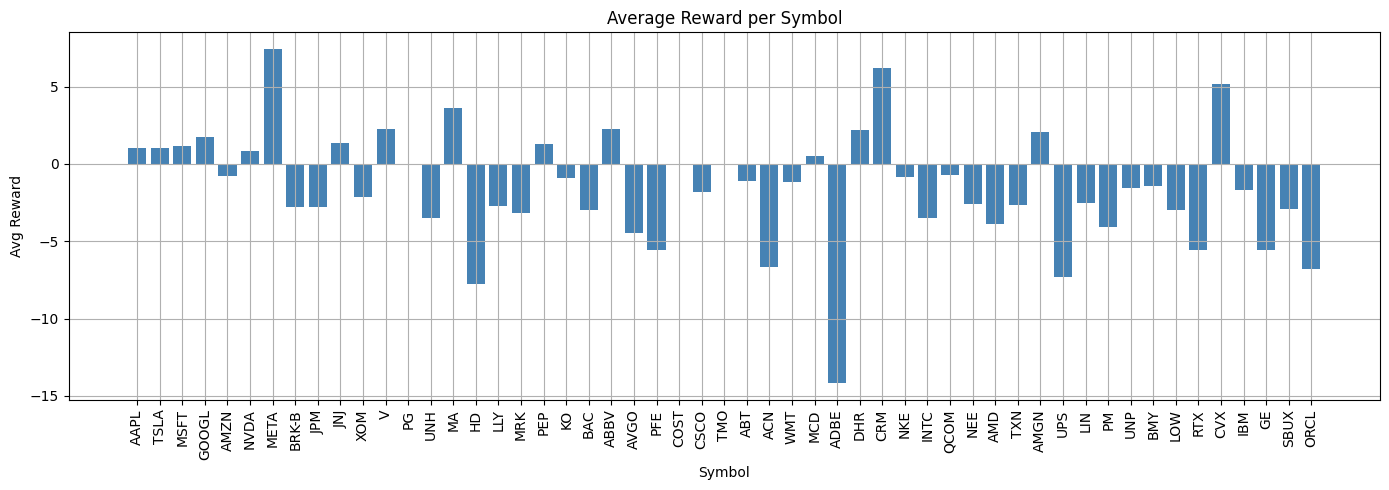

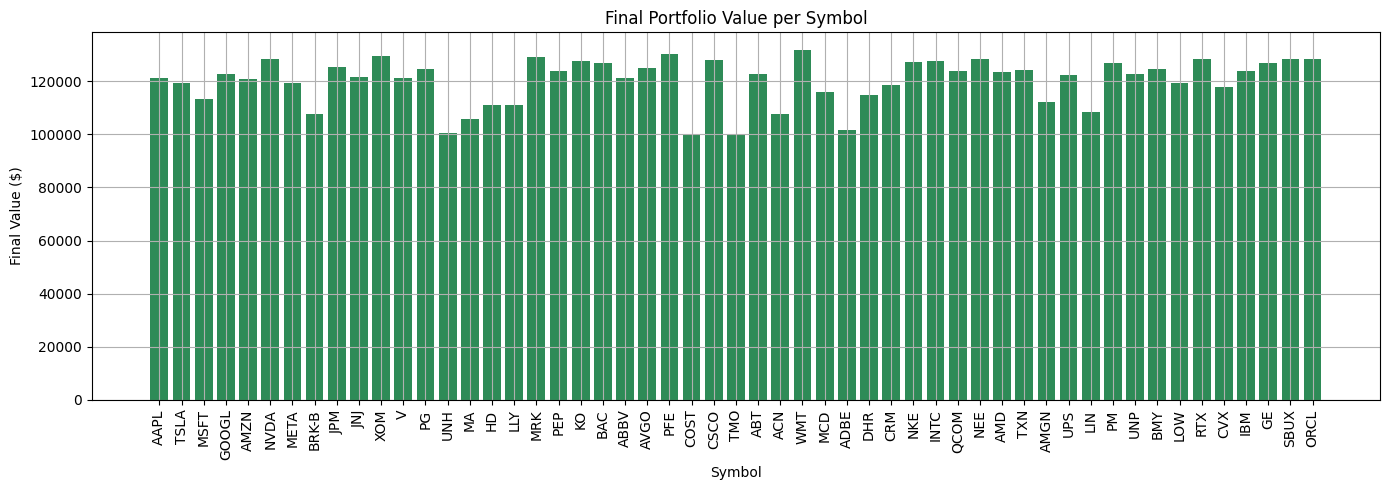

In [20]:
import matplotlib.pyplot as plt

# Plot Avg Reward per Symbol
plt.figure(figsize=(14, 5))
plt.bar(evaluation_df['Symbol'], evaluation_df['AvgReward'], color='steelblue')
plt.title('Average Reward per Symbol')
plt.xlabel('Symbol')
plt.ylabel('Avg Reward')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Final Portfolio Value per Symbol
plt.figure(figsize=(14, 5))
plt.bar(evaluation_df['Symbol'], evaluation_df['FinalPortfolioValue'], color='seagreen')
plt.title('Final Portfolio Value per Symbol')
plt.xlabel('Symbol')
plt.ylabel('Final Value ($)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
from google.colab import drive
drive.mount('/content/drive')
# Define the path in Google Drive
drive_path = "/content/drive/MyDrive/TradingResults"
os.makedirs(drive_path, exist_ok=True)

# Save evaluation results
evaluation_df.to_csv(f"{drive_path}/dqn_evaluation_results.csv", index=False)
print(f"Results saved to {drive_path}/dqn_evaluation_results.csv")


Mounted at /content/drive
Results saved to /content/drive/MyDrive/TradingResults/dqn_evaluation_results.csv
